# Sine Wave Forecasting

Quick notebook to explore GRUs with a toy problem.



1.   Generate sine wave dataset with noise in batches.
2.   Forecast 1 step ahead with last sample (naive forecasting as benchmark)
3. Forecast 1 step ahead with MLP
4. Forecast 10 steps ahead with naive
5. Forecast 10 steps ahead with MLP
5. Forecast 10 steps ahead with GRU



In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorchtools import EarlyStopping

# 1. Generate sine waves dataset

In [2]:
def generate_timeseries(batch_size, n_steps):
    # From chapter 15 HoML
    offset1, offset2 = np.random.rand(2, batch_size,1) # offset shape is (batch_size, 1)
    f1,f2 = np.random.randint(1, 100, (2,batch_size,1)) # f shape is (batch_size, 1)
    t = np.linspace(0,1, n_steps) # 1d array n_steps long
    series = 0.5*np.sin(2*np.pi*t*f1 + offset1*np.pi) # Broadcasting - series shape is (batch_size, n_steps)
    series += 0.2*np.sin(2*np.pi*t*f2 + offset2*np.pi)
    series += 0.1*(np.random.randn(batch_size, n_steps) - 0.5)

    return np.expand_dims(series, axis=-1).astype(np.float32) # expand dims adds extra dimension of size 1 to end - it's a univariate timeseries

In [3]:
forecast_steps = 1 # Number of steps we want to forecast into future
max_n_steps = 1000 # Max sequence length of GRU
n_samples = 14000 # Number of vectors to generate for our dataset from generate_timeseries
series = generate_timeseries(n_samples, max_n_steps + forecast_steps)

In [4]:
X_train, y_train = series[0:10000, 0:max_n_steps, :], series[0:10000, max_n_steps:, :]
X_val, y_val = series[10000:12000, 0:max_n_steps, :], series[10000:12000, max_n_steps:, :]
X_test, y_test = series[12000:14000, 0:max_n_steps, :], series[12000:14000, max_n_steps:, :]

In [5]:
print(X_train.shape,y_train.shape)

(10000, 1000, 1) (10000, 1, 1)


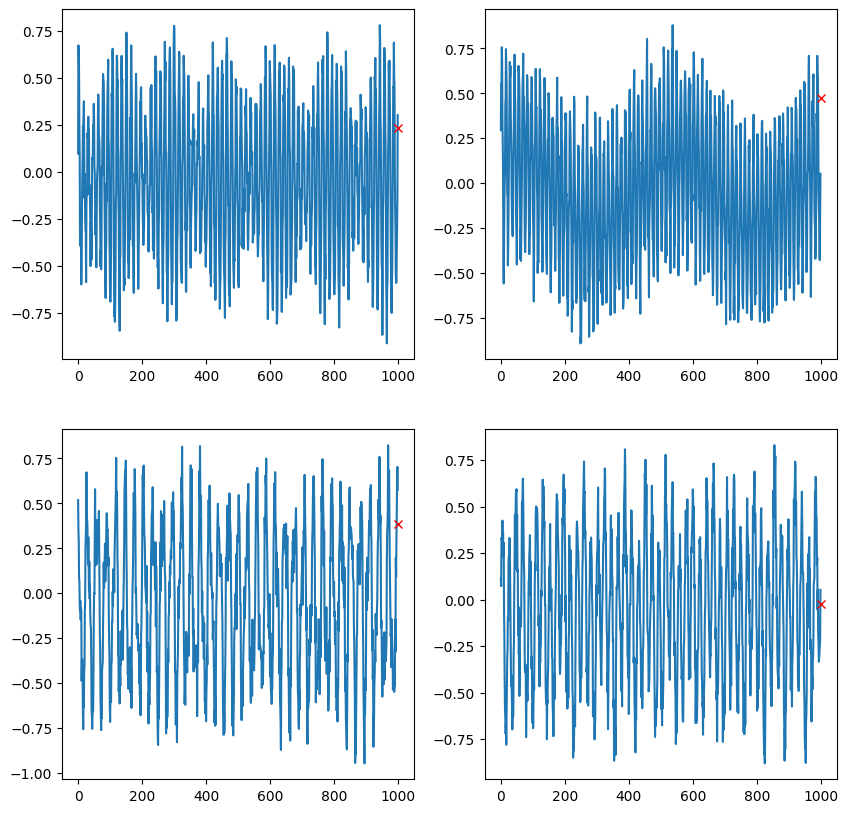

In [6]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax[0,0].plot(X_train[0,:,:])
ax[0,0].plot(max_n_steps+forecast_steps, y_train[0,:,:], marker='x',color='r')

ax[0,1].plot(X_train[1,:,:])
ax[0,1].plot(max_n_steps+forecast_steps, y_train[1,:,:], marker='x',color='r')

ax[1,0].plot(X_train[2,:,:])
ax[1,0].plot(max_n_steps+forecast_steps, y_train[2,:,:], marker='x',color='r')

ax[1,1].plot(X_train[3,:,:])
ax[1,1].plot(max_n_steps+forecast_steps, y_train[3,:,:], marker='x',color='r')

# 2. Naive Benchmark for 1-step forecasting

In [7]:
# Define function for calculating RMSE

def RMSE(preds: np.array, labels: np.array) -> np.float32:
  return np.sqrt(np.mean((preds - labels)**2))

In [8]:
benchmark = RMSE(np.squeeze(X_test[:,-1,:]), np.squeeze(y_test))
print(f'Naive forecasting with last sample RMSE (test): {benchmark}')

Naive forecasting with last sample RMSE (test): 0.20030486583709717


# 3. Benchmark MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, n_feats: int = 64, hidden_layers: list = [64,32,16],
                 n_outputs: int = 1):
        super().__init__()

        self.flatten = nn.Flatten()
        self.BN = nn.BatchNorm1d(n_feats)
        self.linear_relu_stack = nn.Sequential()
        for idx,layer in enumerate(hidden_layers):
            if (idx == 0):
                self.linear_relu_stack.append(nn.Linear(n_feats, layer))
                self.linear_relu_stack.append(nn.ReLU())
            else:
                self.linear_relu_stack.append(nn.Linear(hidden_layers[idx-1], layer))
                self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(hidden_layers[-1],n_outputs))

    def forward(self, X):
        X = self.flatten(X)
        X = self.BN(X)
        return self.linear_relu_stack(X)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            X = self.flatten(X)
            X = self.BN(X)
            return torch.squeeze(self.linear_relu_stack(X)).cpu().numpy()

    def fit(self, train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int = 64,
            learning_rate: float = 1e-3, num_epochs: int = 100, patience: int = 5, delta: float = 0.01,
            device: str = 'cpu'):

        loss_fn = nn.MSELoss()
        optimizer = Adam(self.parameters(), lr = learning_rate)
        early_stopping = EarlyStopping(patience = patience, delta = delta, verbose = True)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
        val_dataloader = DataLoader(val_dataset, batch_size = batch_size,
                                    shuffle = True)
        print('Epoch\t Train Loss\t Val Loss\t Val RMSE')
        for epoch in range(num_epochs):
            train_loss = self.__train(train_dataloader, optimizer, loss_fn,
                                      device)
            val_loss, val_rmse = self.__test(val_dataloader, loss_fn, device)

            print(f'\n{epoch+1}\t {train_loss:.3f}\t\t {val_loss:.3f}\t\t {val_rmse:.2f}')

            early_stopping(val_loss, self)
            if early_stopping.early_stop:
              break

        self.load_state_dict(torch.load('checkpoint.pt'))

    def __train(self, train_dataloader, optimizer, loss_fn, device):
        train_loss = 0
        self.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = torch.squeeze(self(X))
            loss = loss_fn(preds, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        return train_loss

    def __test(self, val_dataloader, loss_fn, device):
        sq_err = 0
        val_loss = 0
        self.eval()
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = torch.squeeze(self(X))
                loss = loss_fn(preds, y)

                val_loss += loss.item()
                sq_err += torch.sum((preds - y)**2).item()

        rmse = np.sqrt(sq_err/len(val_dataloader.dataset))

        return val_loss, rmse

In [10]:
train_data = TensorDataset(torch.squeeze(torch.from_numpy(X_train)), torch.squeeze(torch.from_numpy(y_train)))
val_data = TensorDataset(torch.squeeze(torch.from_numpy(X_val)), torch.squeeze(torch.from_numpy(y_val)))
test_data = TensorDataset(torch.squeeze(torch.from_numpy(X_test)), torch.squeeze(torch.from_numpy(y_test)))

In [11]:
device = 'cuda'
batch_size = 128
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = MLP(n_feats = max_n_steps, hidden_layers = [64,32,16,8], n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 2.710		 0.217		 0.12
Validation loss decreased (inf --> 0.217162).  Saving model ...

2	 0.999		 0.207		 0.11
Validation loss decreased (0.217162 --> 0.206559).  Saving model ...

3	 0.913		 0.200		 0.11
Validation loss decreased (0.206559 --> 0.200425).  Saving model ...

4	 0.819		 0.202		 0.11
EarlyStopping counter: 1 out of 5

5	 0.785		 0.206		 0.11
EarlyStopping counter: 2 out of 5

6	 0.733		 0.211		 0.12
EarlyStopping counter: 3 out of 5

7	 0.694		 0.208		 0.11
EarlyStopping counter: 4 out of 5

8	 0.648		 0.218		 0.12
EarlyStopping counter: 5 out of 5


## 3.1 Decreasing the sequence length for MLP

(10000, 64, 1) (10000, 1, 1)


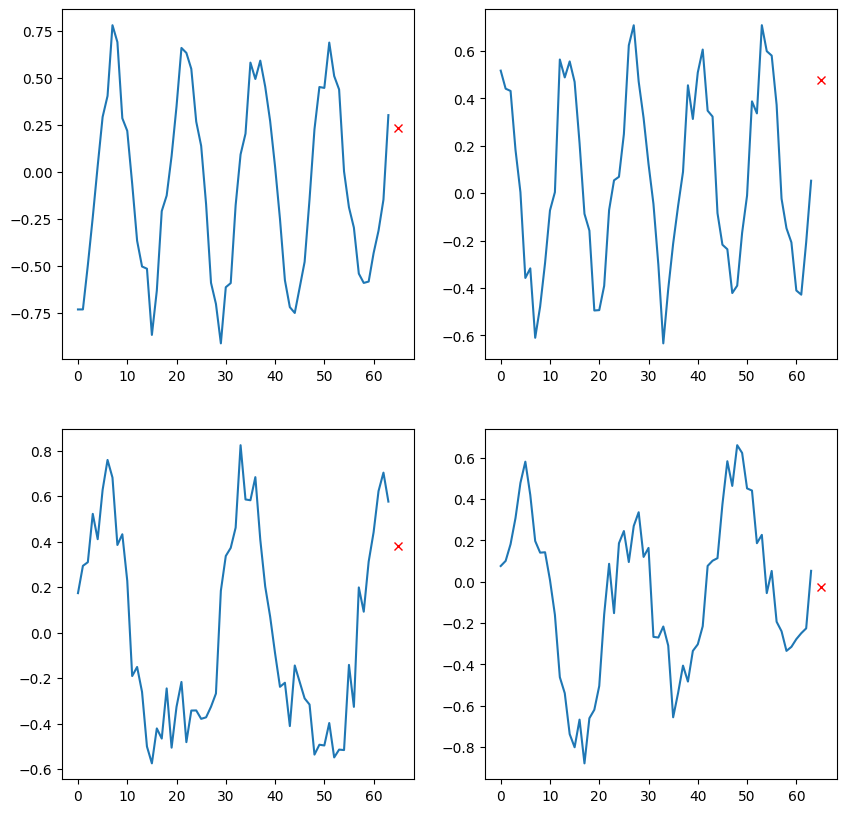

In [12]:
# What if we decrease the sequence length?
X_train, y_train = series[0:10000, max_n_steps-64:max_n_steps, :], series[0:10000, max_n_steps:, :]
X_val, y_val = series[10000:12000, max_n_steps-64:max_n_steps, :], series[10000:12000, max_n_steps:, :]
X_test, y_test = series[12000:14000, max_n_steps-64:max_n_steps, :], series[12000:14000, max_n_steps:, :]

print(X_train.shape,y_train.shape)

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax[0,0].plot(X_train[0,:,:])
ax[0,0].plot(64+forecast_steps, y_train[0,:,:], marker='x',color='r')

ax[0,1].plot(X_train[1,:,:])
ax[0,1].plot(64+forecast_steps, y_train[1,:,:], marker='x',color='r')

ax[1,0].plot(X_train[2,:,:])
ax[1,0].plot(64+forecast_steps, y_train[2,:,:], marker='x',color='r')

ax[1,1].plot(X_train[3,:,:])
ax[1,1].plot(64+forecast_steps, y_train[3,:,:], marker='x',color='r')

train_data = TensorDataset(torch.squeeze(torch.from_numpy(X_train)), torch.squeeze(torch.from_numpy(y_train)))
val_data = TensorDataset(torch.squeeze(torch.from_numpy(X_val)), torch.squeeze(torch.from_numpy(y_val)))
test_data = TensorDataset(torch.squeeze(torch.from_numpy(X_test)), torch.squeeze(torch.from_numpy(y_test)))

In [13]:
device = 'cuda'
batch_size = 128
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = MLP(n_feats = 64, hidden_layers = [64,32,16,8], n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 2.649		 0.379		 0.15
Validation loss decreased (inf --> 0.378656).  Saving model ...

2	 1.683		 0.309		 0.14
Validation loss decreased (0.378656 --> 0.309198).  Saving model ...

3	 1.459		 0.294		 0.14
Validation loss decreased (0.309198 --> 0.293996).  Saving model ...

4	 1.357		 0.283		 0.13
Validation loss decreased (0.293996 --> 0.283034).  Saving model ...

5	 1.311		 0.275		 0.13
Validation loss decreased (0.283034 --> 0.275330).  Saving model ...

6	 1.271		 0.281		 0.13
EarlyStopping counter: 1 out of 5

7	 1.233		 0.271		 0.13
Validation loss decreased (0.275330 --> 0.270693).  Saving model ...

8	 1.202		 0.261		 0.13
Validation loss decreased (0.270693 --> 0.261068).  Saving model ...

9	 1.190		 0.266		 0.13
EarlyStopping counter: 1 out of 5

10	 1.177		 0.277		 0.13
EarlyStopping counter: 2 out of 5

11	 1.156		 0.257		 0.13
Validation loss decreased (0.261068 --> 0.256503).  Saving model ...

12	 1.144		 0.259		 0.13
EarlyStopp

So the MLP doesn't improve with a smaller sequence length.

Note that many other experiments are not shown here in this notebook due to constaints with GPU memory on Colab.

# 3.2 Evaluating best MLP on test set

Retrain first, then evaluate on test set.

In [14]:
X_train, y_train = series[0:10000, 0:max_n_steps, :], series[0:10000, max_n_steps:, :]
X_val, y_val = series[10000:12000, 0:max_n_steps, :], series[10000:12000, max_n_steps:, :]
X_test, y_test = series[12000:14000, 0:max_n_steps, :], series[12000:14000, max_n_steps:, :]

print(X_train.shape,y_train.shape)

train_data = TensorDataset(torch.squeeze(torch.from_numpy(X_train)), torch.squeeze(torch.from_numpy(y_train)))
val_data = TensorDataset(torch.squeeze(torch.from_numpy(X_val)), torch.squeeze(torch.from_numpy(y_val)))
X_test_torch, y_test_torch = torch.squeeze(torch.from_numpy(X_test)).to(device), torch.squeeze(torch.from_numpy(y_test)).to(device)

(10000, 1000, 1) (10000, 1, 1)


In [15]:
device = 'cuda'
batch_size = 128
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = MLP(n_feats = max_n_steps, hidden_layers = [64,32,16,8], n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 3.466		 0.218		 0.12
Validation loss decreased (inf --> 0.218049).  Saving model ...

2	 1.024		 0.207		 0.11
Validation loss decreased (0.218049 --> 0.206819).  Saving model ...

3	 0.893		 0.213		 0.12
EarlyStopping counter: 1 out of 5

4	 0.829		 0.212		 0.12
EarlyStopping counter: 2 out of 5

5	 0.768		 0.213		 0.11
EarlyStopping counter: 3 out of 5

6	 0.744		 0.211		 0.11
EarlyStopping counter: 4 out of 5

7	 0.717		 0.216		 0.12
EarlyStopping counter: 5 out of 5


In [16]:
preds = model.predict(X_test_torch)
RMSE(preds, np.squeeze(y_test))

0.11108357

# 4. Forecasting 1 step ahead with GRU

In [17]:
X_train, y_train = series[0:10000, 0:max_n_steps, :], series[0:10000, max_n_steps:, :]
X_val, y_val = series[10000:12000, 0:max_n_steps, :], series[10000:12000, max_n_steps:, :]
X_test, y_test = series[12000:14000, 0:max_n_steps, :], series[12000:14000, max_n_steps:, :]

print(X_train.shape,y_train.shape)

device = 'cuda'
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
X_test_torch, y_test_torch = torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device)

(10000, 1000, 1) (10000, 1, 1)


In [18]:
class GRU(nn.Module):
    def __init__(self, n_feats: int = 1, n_hidden: int = 1, n_layers: int = 1,
                 batch_first: bool = True, dropout: float = 0.0,
                 bidir: bool = False, n_outputs: int = 1):
        super().__init__()
        self.n_gru_layers = n_layers
        self.gru_layer = nn.GRU(input_size = n_feats, hidden_size = n_hidden,
                                num_layers = n_layers, batch_first = batch_first,
                                dropout = dropout, bidirectional = bidir)
        self.linear = nn.Linear(n_hidden, n_outputs)

    def forward(self, X):
        _, h_n = self.gru_layer(X)
        return self.linear(h_n)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            _, h_n = self.gru_layer(X)
            if (self.n_gru_layers > 1):
                return torch.squeeze(self.linear(h_n)[-1,:,:]).cpu().numpy()
            else:
                return torch.squeeze(self.linear(h_n)).cpu().numpy()

    def fit(self, train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int = 64,
            learning_rate: float = 1e-3, num_epochs: int = 100, patience: int = 5, delta: float = 0.01,
            device: str = 'cpu'):

        loss_fn = nn.MSELoss()
        optimizer = Adam(self.parameters(), lr = learning_rate)
        early_stopping = EarlyStopping(patience = patience, delta = delta, verbose = True)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
        val_dataloader = DataLoader(val_dataset, batch_size = batch_size,
                                    shuffle = True)
        print('Epoch\t Train Loss\t Val Loss\t Val RMSE')
        for epoch in range(num_epochs):
            train_loss = self.__train(train_dataloader, optimizer, loss_fn,
                                      device)
            val_loss, val_rmse = self.__test(val_dataloader, loss_fn, device)

            print(f'\n{epoch+1}\t {train_loss:.3f}\t\t {val_loss:.3f}\t\t {val_rmse:.2f}')

            early_stopping(val_loss, self)
            if early_stopping.early_stop:
              break

        self.load_state_dict(torch.load('checkpoint.pt'))

    def __train(self, train_dataloader, optimizer, loss_fn, device):
        train_loss = 0
        self.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = self(X)
            if (self.n_gru_layers > 1):
                preds = preds[-1,:,:]

            preds = torch.squeeze(preds)
            y = torch.squeeze(y)
            loss = loss_fn(preds, y)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return train_loss

    def __test(self, val_dataloader, loss_fn, device):
        sq_err = 0
        val_loss = 0
        self.eval()
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = self(X)
                if (self.n_gru_layers > 1):
                    preds = preds[-1,:,:]

                preds = torch.squeeze(preds)
                y = torch.squeeze(y)
                loss = loss_fn(preds, y)
                val_loss += loss.item()
                sq_err += torch.sum((preds - y)**2).item()

        rmse = np.sqrt(sq_err/len(val_dataloader.dataset))

        return val_loss, rmse

In [19]:
device = 'cuda'
batch_size = 64
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = GRU(n_feats = 1, n_hidden = 64, n_layers = 1, batch_first = True, n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 5.762		 0.802		 0.16
Validation loss decreased (inf --> 0.801752).  Saving model ...

2	 3.581		 0.695		 0.15
Validation loss decreased (0.801752 --> 0.694982).  Saving model ...

3	 3.288		 0.666		 0.14
Validation loss decreased (0.694982 --> 0.665901).  Saving model ...

4	 3.193		 0.647		 0.14
Validation loss decreased (0.665901 --> 0.646847).  Saving model ...

5	 3.070		 0.609		 0.14
Validation loss decreased (0.646847 --> 0.609012).  Saving model ...

6	 2.958		 0.618		 0.14
EarlyStopping counter: 1 out of 5

7	 2.941		 0.600		 0.14
Validation loss decreased (0.609012 --> 0.599694).  Saving model ...

8	 2.903		 0.605		 0.14
EarlyStopping counter: 1 out of 5

9	 2.859		 0.582		 0.13
Validation loss decreased (0.599694 --> 0.582095).  Saving model ...

10	 2.813		 0.582		 0.13
Validation loss decreased (0.582095 --> 0.581987).  Saving model ...

11	 2.806		 0.575		 0.13
Validation loss decreased (0.581987 --> 0.574703).  Saving model ...



In [20]:
device = 'cuda'
batch_size = 64
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = GRU(n_feats = 1, n_hidden = 128, n_layers = 1, batch_first = True, n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 5.375		 0.709		 0.15
Validation loss decreased (inf --> 0.708993).  Saving model ...

2	 3.359		 0.657		 0.14
Validation loss decreased (0.708993 --> 0.656869).  Saving model ...

3	 3.135		 0.650		 0.14
Validation loss decreased (0.656869 --> 0.650353).  Saving model ...

4	 2.991		 0.629		 0.14
Validation loss decreased (0.650353 --> 0.628821).  Saving model ...

5	 2.922		 0.595		 0.14
Validation loss decreased (0.628821 --> 0.594753).  Saving model ...

6	 2.906		 0.593		 0.14
Validation loss decreased (0.594753 --> 0.592661).  Saving model ...

7	 2.879		 0.582		 0.13
Validation loss decreased (0.592661 --> 0.581609).  Saving model ...

8	 2.849		 0.563		 0.13
Validation loss decreased (0.581609 --> 0.562851).  Saving model ...

9	 2.773		 0.551		 0.13
Validation loss decreased (0.562851 --> 0.550745).  Saving model ...

10	 2.726		 0.576		 0.13
EarlyStopping counter: 1 out of 5

11	 2.691		 0.561		 0.13
EarlyStopping counter: 2 out of 5



# 4.1 Evaluating on Test set

In [21]:
device = 'cuda'
batch_size = 64
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = GRU(n_feats = 1, n_hidden = 32, n_layers = 1, batch_first = True, n_outputs = 1).to(device)
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 4.977		 0.778		 0.16
Validation loss decreased (inf --> 0.778145).  Saving model ...

2	 3.546		 0.712		 0.15
Validation loss decreased (0.778145 --> 0.711534).  Saving model ...

3	 3.307		 0.690		 0.15
Validation loss decreased (0.711534 --> 0.690426).  Saving model ...

4	 3.210		 0.672		 0.14
Validation loss decreased (0.690426 --> 0.672217).  Saving model ...

5	 3.022		 0.609		 0.14
Validation loss decreased (0.672217 --> 0.608980).  Saving model ...

6	 2.943		 0.597		 0.14
Validation loss decreased (0.608980 --> 0.597222).  Saving model ...

7	 2.848		 0.597		 0.14
Validation loss decreased (0.597222 --> 0.597179).  Saving model ...

8	 2.789		 0.591		 0.14
Validation loss decreased (0.597179 --> 0.591302).  Saving model ...

9	 2.748		 0.554		 0.13
Validation loss decreased (0.591302 --> 0.553839).  Saving model ...

10	 2.696		 0.552		 0.13
Validation loss decreased (0.553839 --> 0.552011).  Saving model ...

11	 2.657		 0.559		 0.13


In [22]:
preds = model.predict(X_test_torch)
RMSE(preds, np.squeeze(y_test))

0.123058856

# 5. Forecasting 10 timesteps ahead

(10000, 1000, 1) (10000, 10, 1)


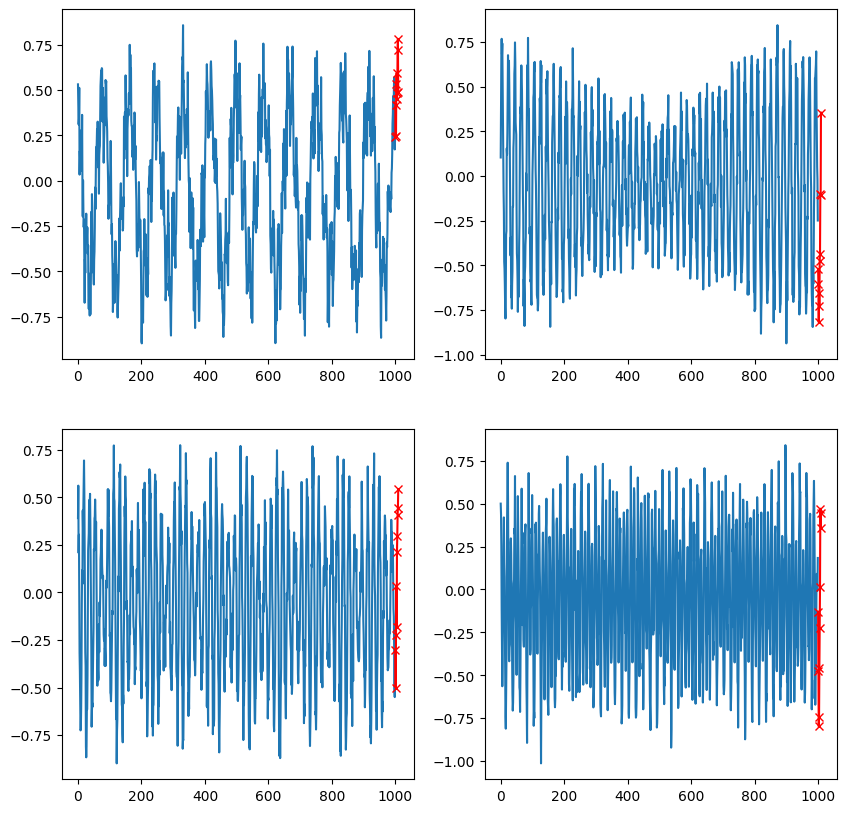

In [23]:
forecast_steps = 10 # Number of steps we want to forecast into future
max_n_steps = 1000 # Max sequence length of GRU
n_samples = 14000 # Number of vectors to generate for our dataset from generate_timeseries
series = generate_timeseries(n_samples, max_n_steps + forecast_steps)

X_train, y_train = series[0:10000, 0:max_n_steps, :], series[0:10000, max_n_steps:, :]
X_val, y_val = series[10000:12000, 0:max_n_steps, :], series[10000:12000, max_n_steps:, :]
X_test, y_test = series[12000:14000, 0:max_n_steps, :], series[12000:14000, max_n_steps:, :]

print(X_train.shape,y_train.shape)

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax[0,0].plot(X_train[0,:,:])
ax[0,0].plot(np.arange(max_n_steps, max_n_steps+forecast_steps), y_train[0,:,:], marker='x',color='r')

ax[0,1].plot(X_train[1,:,:])
ax[0,1].plot(np.arange(max_n_steps, max_n_steps+forecast_steps), y_train[1,:,:], marker='x',color='r')

ax[1,0].plot(X_train[2,:,:])
ax[1,0].plot(np.arange(max_n_steps, max_n_steps+forecast_steps), y_train[2,:,:], marker='x',color='r')

ax[1,1].plot(X_train[3,:,:])
ax[1,1].plot(np.arange(max_n_steps, max_n_steps+forecast_steps), y_train[3,:,:], marker='x',color='r')

In [24]:
benchmark = RMSE(X_test[:,-1,:], np.squeeze(y_test))
print(f'Naive forecasting with last sample RMSE (test): {benchmark}')

Naive forecasting with last sample RMSE (test): 0.540353000164032


In [25]:
class MLP(nn.Module):
    def __init__(self, n_feats: int = 64, hidden_layers: list = [64,32,16],
                 n_outputs: int = 1):
        super().__init__()

        self.flatten = nn.Flatten()
        self.BN = nn.BatchNorm1d(n_feats)
        self.linear_relu_stack = nn.Sequential()
        for idx,layer in enumerate(hidden_layers):
            if (idx == 0):
                self.linear_relu_stack.append(nn.Linear(n_feats, layer))
                self.linear_relu_stack.append(nn.ReLU())
            else:
                self.linear_relu_stack.append(nn.Linear(hidden_layers[idx-1], layer))
                self.linear_relu_stack.append(nn.ReLU())
        self.linear_relu_stack.append(nn.Linear(hidden_layers[-1],n_outputs))

    def forward(self, X):
        X = self.flatten(X)
        X = self.BN(X)
        return self.linear_relu_stack(X)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            X = self.flatten(X)
            X = self.BN(X)
            return torch.squeeze(self.linear_relu_stack(X)).cpu().numpy()

    def fit(self, train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int = 64,
            learning_rate: float = 1e-3, num_epochs: int = 100, patience: int = 5, delta: float = 0.01,
            device: str = 'cpu'):

        loss_fn = nn.MSELoss()
        optimizer = Adam(self.parameters(), lr = learning_rate)
        early_stopping = EarlyStopping(patience = patience, delta = delta, verbose = True)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
        val_dataloader = DataLoader(val_dataset, batch_size = batch_size,
                                    shuffle = True)
        print('Epoch\t Train Loss\t Val Loss\t Val RMSE')
        for epoch in range(num_epochs):
            train_loss = self.__train(train_dataloader, optimizer, loss_fn,
                                      device)
            val_loss, val_rmse = self.__test(val_dataloader, loss_fn, device)

            print(f'\n{epoch+1}\t {train_loss:.3f}\t\t {val_loss:.3f}\t\t {val_rmse:.2f}')

            early_stopping(val_loss, self)
            if early_stopping.early_stop:
              break

        self.load_state_dict(torch.load('checkpoint.pt'))

    def __train(self, train_dataloader, optimizer, loss_fn, device):
        train_loss = 0
        self.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = self(X)
            loss = loss_fn(preds, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        return train_loss

    def __test(self, val_dataloader, loss_fn, device):
        sq_err = 0
        val_loss = 0
        self.eval()
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = self(X)
                loss = loss_fn(preds, y)

                val_loss += loss.item()
                sq_err += torch.sum((preds - y)**2).item()

        rmse = np.sqrt(sq_err/(val_dataloader.dataset[:][1].shape[0]*val_dataloader.dataset[:][1].shape[1]))

        return val_loss, rmse

In [26]:
print(X_train.shape,y_train.shape)
device='cuda'
train_data = TensorDataset(torch.squeeze(torch.from_numpy(X_train)), torch.squeeze(torch.from_numpy(y_train)))
val_data = TensorDataset(torch.squeeze(torch.from_numpy(X_val)), torch.squeeze(torch.from_numpy(y_val)))
X_test_torch, y_test_torch = torch.squeeze(torch.from_numpy(X_test)).to(device), torch.squeeze(torch.from_numpy(y_test)).to(device)

(10000, 1000, 1) (10000, 10, 1)


In [27]:
device = 'cuda'
batch_size = 128
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = MLP(n_feats = max_n_steps, hidden_layers = [64,32,16,8], n_outputs = 10).to(device)
print(RMSE(model.predict(X_test_torch), np.squeeze(y_test)))
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

0.44308558
Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 10.461		 1.084		 0.26
Validation loss decreased (inf --> 1.083526).  Saving model ...

2	 3.416		 0.497		 0.18
Validation loss decreased (1.083526 --> 0.497094).  Saving model ...

3	 1.995		 0.395		 0.16
Validation loss decreased (0.497094 --> 0.395479).  Saving model ...

4	 1.640		 0.364		 0.15
Validation loss decreased (0.395479 --> 0.364313).  Saving model ...

5	 1.455		 0.340		 0.15
Validation loss decreased (0.364313 --> 0.339762).  Saving model ...

6	 1.346		 0.325		 0.14
Validation loss decreased (0.339762 --> 0.324846).  Saving model ...

7	 1.275		 0.318		 0.14
Validation loss decreased (0.324846 --> 0.317603).  Saving model ...

8	 1.241		 0.312		 0.14
Validation loss decreased (0.317603 --> 0.311913).  Saving model ...

9	 1.216		 0.311		 0.14
Validation loss decreased (0.311913 --> 0.310881).  Saving model ...

10	 1.121		 0.302		 0.14
Validation loss decreased (0.310881 --> 0.302307).  Saving model ...

11	 1.108		 0

In [28]:
preds = model.predict(X_test_torch)
RMSE(preds, np.squeeze(y_test))

0.1323185

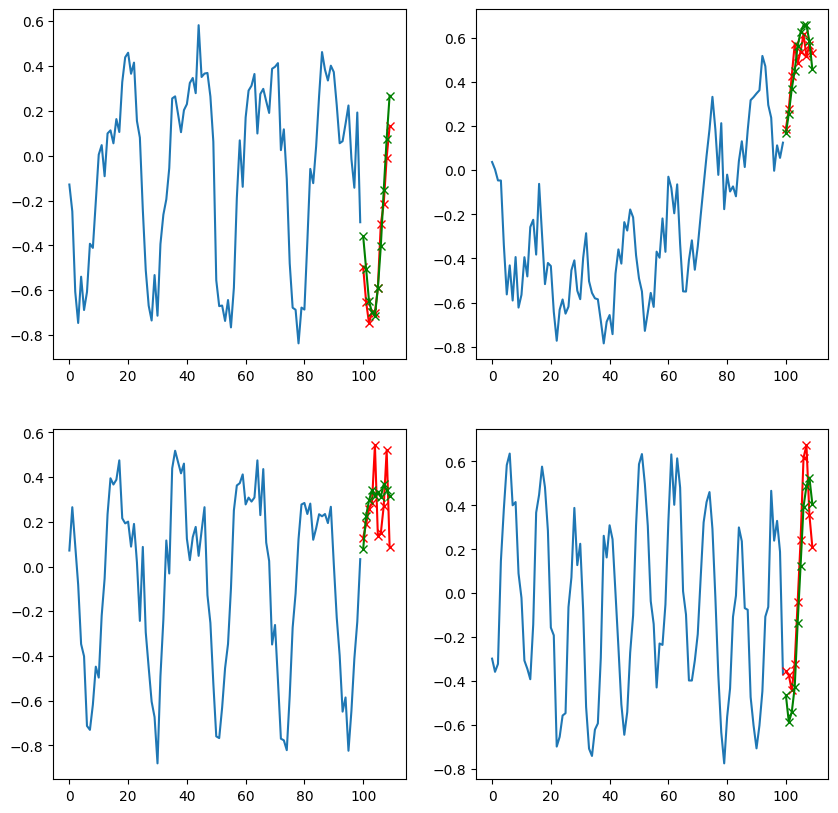

In [29]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

a,b,c,d = np.random.randint(0,2000,4)

ax[0,0].plot(X_test[a,-100:,:])
ax[0,0].plot(np.arange(100, 100+forecast_steps), y_test[a,:,:], marker='x',color='r')
ax[0,0].plot(np.arange(100, 100+forecast_steps), preds[a,:], marker='x',color='g')

ax[0,1].plot(X_test[b,-100:,:])
ax[0,1].plot(np.arange(100, 100+forecast_steps), y_test[b,:,:], marker='x',color='r')
ax[0,1].plot(np.arange(100, 100+forecast_steps), preds[b,:], marker='x',color='g')

ax[1,0].plot(X_test[c,-100:,:])
ax[1,0].plot(np.arange(100, 100+forecast_steps), y_test[c,:,:], marker='x',color='r')
ax[1,0].plot(np.arange(100, 100+forecast_steps), preds[c,:], marker='x',color='g')

ax[1,1].plot(X_test[d,-100:,:])
ax[1,1].plot(np.arange(100, 100+forecast_steps), y_test[d,:,:], marker='x',color='r')
ax[1,1].plot(np.arange(100, 100+forecast_steps), preds[d,:], marker='x',color='g')

In [30]:
class GRU(nn.Module):
    def __init__(self, n_feats: int = 1, n_hidden: int = 1, n_layers: int = 1,
                 batch_first: bool = True, dropout: float = 0.0,
                 bidir: bool = False, n_outputs: int = 1):
        super().__init__()
        self.n_gru_layers = n_layers
        self.gru_layer = nn.GRU(input_size = n_feats, hidden_size = n_hidden,
                                num_layers = n_layers, batch_first = batch_first,
                                dropout = dropout, bidirectional = bidir)
        self.linear = nn.Linear(n_hidden, n_outputs)

    def forward(self, X):
        _, h_n = self.gru_layer(X)
        return self.linear(h_n)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            _, h_n = self.gru_layer(X)
            if (self.n_gru_layers > 1):
                return torch.squeeze(self.linear(h_n)[-1,:,:]).cpu().numpy()
            else:
                return torch.squeeze(self.linear(h_n)).cpu().numpy()

    def fit(self, train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int = 64,
            learning_rate: float = 1e-3, num_epochs: int = 100, patience: int = 5, delta: float = 0.01,
            device: str = 'cpu'):

        loss_fn = nn.MSELoss()
        optimizer = Adam(self.parameters(), lr = learning_rate)
        early_stopping = EarlyStopping(patience = patience, delta = delta, verbose = True)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
        val_dataloader = DataLoader(val_dataset, batch_size = batch_size,
                                    shuffle = True)
        print('Epoch\t Train Loss\t Val Loss\t Val RMSE')
        for epoch in range(num_epochs):
            train_loss = self.__train(train_dataloader, optimizer, loss_fn,
                                      device)
            val_loss, val_rmse = self.__test(val_dataloader, loss_fn, device)

            print(f'\n{epoch+1}\t {train_loss:.3f}\t\t {val_loss:.3f}\t\t {val_rmse:.2f}')

            early_stopping(val_loss, self)
            if early_stopping.early_stop:
              break

        self.load_state_dict(torch.load('checkpoint.pt'))

    def __train(self, train_dataloader, optimizer, loss_fn, device):
        train_loss = 0
        self.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = self(X)
            if (self.n_gru_layers > 1):
                preds = preds[-1,:,:]

            preds = torch.squeeze(preds)
            y = torch.squeeze(y)

            loss = loss_fn(preds, y)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return train_loss

    def __test(self, val_dataloader, loss_fn, device):
        sq_err = 0
        val_loss = 0
        self.eval()
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = self(X)
                if (self.n_gru_layers > 1):
                    preds = preds[-1,:,:]

                preds = torch.squeeze(preds)
                y = torch.squeeze(y)
                loss = loss_fn(preds, y)
                val_loss += loss.item()
                sq_err += torch.sum((preds - y)**2).item()

        rmse = np.sqrt(sq_err/(val_dataloader.dataset[:][1].shape[0]*val_dataloader.dataset[:][1].shape[1]))

        return val_loss, rmse

In [31]:
device = 'cuda'
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
X_test_torch, y_test_torch = torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device)

In [32]:
device = 'cuda'
batch_size = 64
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = GRU(n_feats = 1, n_hidden = 64, n_layers = 1, batch_first = True, n_outputs = 10).to(device)
print(RMSE(model.predict(X_test_torch), np.squeeze(y_test)))
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

0.43476194
Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 16.654		 2.512		 0.28
Validation loss decreased (inf --> 2.511515).  Saving model ...

2	 10.660		 1.801		 0.24
Validation loss decreased (2.511515 --> 1.801325).  Saving model ...

3	 8.164		 1.446		 0.21
Validation loss decreased (1.801325 --> 1.446390).  Saving model ...

4	 9.242		 1.332		 0.20
Validation loss decreased (1.446390 --> 1.331985).  Saving model ...

5	 9.052		 3.064		 0.31
EarlyStopping counter: 1 out of 5

6	 11.999		 1.681		 0.23
EarlyStopping counter: 2 out of 5

7	 6.994		 1.243		 0.20
Validation loss decreased (1.331985 --> 1.243453).  Saving model ...

8	 5.996		 1.155		 0.19
Validation loss decreased (1.243453 --> 1.154804).  Saving model ...

9	 5.744		 1.105		 0.19
Validation loss decreased (1.154804 --> 1.104703).  Saving model ...

10	 5.397		 1.034		 0.18
Validation loss decreased (1.104703 --> 1.034281).  Saving model ...

11	 5.164		 1.017		 0.18
Validation loss decreased (1.034281 --> 1.017297).  Savi

In [33]:
preds = model.predict(X_test_torch)
RMSE(preds, np.squeeze(y_test))

0.13253155

# Training on every step in the sequence:

In [34]:
class GRU(nn.Module):
    def __init__(self, n_feats: int = 1, n_hidden: int = 1, n_layers: int = 1,
                 batch_first: bool = True, dropout: float = 0.0,
                 bidir: bool = False, n_outputs: int = 1):
        super().__init__()
        self.n_gru_layers = n_layers
        self.gru_layer = nn.GRU(input_size = n_feats, hidden_size = n_hidden,
                                num_layers = n_layers, batch_first = batch_first,
                                dropout = dropout, bidirectional = bidir)
        self.linear = nn.Linear(n_hidden, n_outputs)

    def forward(self, X):
        h, h_n = self.gru_layer(X)
        return self.linear(h)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            h, h_n = self.gru_layer(X)
            return torch.squeeze(self.linear(h)[:,-1,:]).cpu().numpy()

    def fit(self, train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int = 64,
            learning_rate: float = 1e-3, num_epochs: int = 100, patience: int = 5, delta: float = 0.01,
            device: str = 'cpu'):

        loss_fn = nn.MSELoss()
        optimizer = Adam(self.parameters(), lr = learning_rate)
        early_stopping = EarlyStopping(patience = patience, delta = delta, verbose = True)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
        val_dataloader = DataLoader(val_dataset, batch_size = batch_size,
                                    shuffle = True)
        print('Epoch\t Train Loss\t Val Loss\t Val RMSE')
        for epoch in range(num_epochs):
            train_loss = self.__train(train_dataloader, optimizer, loss_fn,
                                      device)
            val_loss, val_rmse = self.__test(val_dataloader, loss_fn, device)

            print(f'\n{epoch+1}\t {train_loss:.3f}\t\t {val_loss:.3f}\t\t {val_rmse:.2f}')

            early_stopping(val_loss, self)
            if early_stopping.early_stop:
              break

        self.load_state_dict(torch.load('checkpoint.pt'))

    def __train(self, train_dataloader, optimizer, loss_fn, device):
        train_loss = 0
        self.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = self(X)
            #preds = torch.squeeze(preds)
            #y = torch.squeeze(y)

            loss = loss_fn(preds, y)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return train_loss

    def __test(self, val_dataloader, loss_fn, device):
        sq_err = 0
        val_loss = 0
        self.eval()
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_dataloader):
                X, y = X.to(device), y.to(device)
                preds = self(X)

                #preds = torch.squeeze(preds)
                #y = torch.squeeze(y)
                loss = loss_fn(preds, y)
                val_loss += loss.item()
                sq_err += torch.sum((preds[:,-1,:] - y[:,-1,:])**2).item()

        rmse = np.sqrt(sq_err/(val_dataloader.dataset[:][1].shape[0]*val_dataloader.dataset[:][1].shape[2]))

        return val_loss, rmse

In [35]:
series.shape

(14000, 1010, 1)

In [36]:
series[:,1:1+max_n_steps,0].shape

(14000, 1000)

In [37]:
Y = np.empty((n_samples, max_n_steps, forecast_steps))

for step_ahead in range(1,11,1):
  Y[:,:,step_ahead-1] = series[:,step_ahead:step_ahead+max_n_steps,0]

y_train = Y[:10000]
y_val = Y[10000:12000]
y_test = Y[12000:14000]

In [38]:
print(X_train.shape,y_train.shape)

(10000, 1000, 1) (10000, 1000, 10)


In [39]:
device = 'cuda'
train_data = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train.astype(np.float32)))
val_data = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.float32)))
X_test_torch, y_test_torch = torch.from_numpy(X_test.astype(np.float32)).to(device), torch.from_numpy(y_test.astype(np.float32)).to(device)

In [40]:
device = 'cuda'
batch_size = 64
lr = 1e-3
num_epochs = 100
patience = 5
delta = 0

model = GRU(n_feats = 1, n_hidden = 64, n_layers = 2, batch_first = True, n_outputs = 10).to(device)
print(RMSE(model.predict(X_test_torch), np.squeeze(y_test[:,-1,:])))
model.fit(train_data, val_data, batch_size, lr, num_epochs, patience, delta, device)

0.41984773424759153
Epoch	 Train Loss	 Val Loss	 Val RMSE

1	 19.145		 3.078		 0.34
Validation loss decreased (inf --> 3.078329).  Saving model ...

2	 11.203		 1.400		 0.21
Validation loss decreased (3.078329 --> 1.400175).  Saving model ...

3	 6.269		 1.175		 0.19
Validation loss decreased (1.400175 --> 1.174549).  Saving model ...

4	 5.658		 1.104		 0.18
Validation loss decreased (1.174549 --> 1.104048).  Saving model ...

5	 6.171		 1.087		 0.18
Validation loss decreased (1.104048 --> 1.087282).  Saving model ...

6	 5.291		 1.033		 0.17
Validation loss decreased (1.087282 --> 1.032639).  Saving model ...

7	 5.118		 1.013		 0.17
Validation loss decreased (1.032639 --> 1.012562).  Saving model ...

8	 5.002		 1.007		 0.17
Validation loss decreased (1.012562 --> 1.006933).  Saving model ...

9	 4.929		 0.996		 0.17
Validation loss decreased (1.006933 --> 0.996127).  Saving model ...

10	 4.852		 1.041		 0.18
EarlyStopping counter: 1 out of 5

11	 4.801		 0.992		 0.17
Validation lo

In [41]:
print(RMSE(model.predict(X_test_torch), np.squeeze(y_test[:,-1,:])))

0.13681245671145603


So the GRU was actually outperformed by the MLP in this toy example. It's possible that with more complex sequence data that the GRU would win. It's worth noting that the GRU is still much more efficient in parameters compared to the MLP: 3(1x64 + 64 + 64x64 + 64) + 64x10 + 10 = 13514 vs 1000x64 + 64 + 64x32 + 32 + 32x16 + 16 + 16x8 + 8 + 8x10 + 10 = 66898.

It's also possible that with some more tuning both of these architectures could've performed better - I did do some limited experiments that I then deleted to conserve memory in Colab, and this combination of hyperparameters was the best of those. Since this was just a toy example to get back up to speed with Pytorch I didn't want to spend any more time creating new notebooks to tune architectures.

I now have Colab Pro, so in future for more in depth projects I'll be expanding my architecture search and experiments.